# Predict future sales

https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview
In this Coursera Kaggle course, there are shop transaction records. It asked you to predict the total number of each different item will be sold in each shop in November 2015.

In [399]:
import _pickle as pickle
import numpy as np
import pandas as pd 
import sklearn
import scipy.sparse 
import lightgbm 
import pandas as pd
import numpy as np
import os
import gc
import matplotlib.pyplot as plt

%matplotlib inline 

for p in [np, pd, scipy, sklearn, lightgbm]:
    print (p.__name__, p.__version__)
##check the package versions.

numpy 1.16.4
pandas 0.24.2
scipy 1.2.1
sklearn 0.21.2
lightgbm 2.3.0


### Load the data

In [400]:
DATA_FOLDER = 'C:/Users/xianyua/github/predict_future_sales/'

transactions    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
test            = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))#November 2015 need to predict
sample          =pd.read_csv(os.path.join(DATA_FOLDER, 'sample_submission.csv.gz'))

### Take a look of all the files

In [401]:
print(transactions.shape)
print(transactions.head())
print('item dimension:', items.shape)
print(items.head())
print('item_categories dimension:', item_categories.shape)
print(item_categories.head())
print('shop dimensionL:', shops.shape)
print(shops.head())
print('test dimension:', test.shape)
print(test.head())
print('sample dimension:', sample.shape)
print(sample.head())

(2935849, 6)
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
item dimension: (22170, 3)
                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4              

'sales' contains all the transaction records including the date, the item id, the shop id, the item price and the number of item sold or returned.

'items' contains the item name and its corresponding item id.

'item categories' contains the item id and its item category id and catergory name.

'shops' contains the shop id and its shop name.

After translating a few words using Google translate, the first part of the item category appears as a higher catergory type. Thus I decided to extract the word before the first space.Similarly the first part of the shop names appear as names of cities.

In [402]:
item_categories['item_category_meta']=item_categories['item_category_name'].str.split(' ').map(lambda x: x[0])
#extract the first words in the item category name
shops['city']=shops['shop_name'].str.split(' ').map(lambda x: x[0])
#extract the first words in the shop name as city name
print(item_categories.head())
print(shops.head())

        item_category_name  item_category_id item_category_meta
0  PC - Гарнитуры/Наушники                 0                 PC
1         Аксессуары - PS2                 1         Аксессуары
2         Аксессуары - PS3                 2         Аксессуары
3         Аксессуары - PS4                 3         Аксессуары
4         Аксессуары - PSP                 4         Аксессуары
                        shop_name  shop_id      city
0   !Якутск Орджоникидзе, 56 фран        0   !Якутск
1   !Якутск ТЦ "Центральный" фран        1   !Якутск
2                Адыгея ТЦ "Мега"        2    Адыгея
3  Балашиха ТРК "Октябрь-Киномир"        3  Балашиха
4        Волжский ТЦ "Волга Молл"        4  Волжский


In [403]:
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)
transactions.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


### Add some potentially useful variables

In [404]:
sales=transactions
sales['day'] = pd.to_datetime(sales['date'], format = '%d.%m.%Y').dt.day
sales['month'] = pd.to_datetime(sales['date'], format = '%d.%m.%Y').dt.month
sales['year'] = pd.to_datetime(sales['date'], format = '%d.%m.%Y').dt.year
sales['weekday'] = pd.to_datetime(sales['date'], format = '%d.%m.%Y').dt.dayofweek
sales=sales.merge(items, how='left')
sales=sales.merge(item_categories,how="left")
sales=sales.merge(shops,how="left")
sales['revenue']=sales['item_cnt_day']*sales['item_price']
#I calculated the revenue per transactions by multiply item price with the number sold (item_cnt_day)

In [405]:
#For reduce amount of computation, I gonna only use the shops and item appears in the final test set
print('previous sale record:',sales.shape[0])
sales=sales[sales['shop_id'].isin (np.sort(test.shop_id.unique()))]
sales=sales[sales['item_id'].isin (np.sort(test.item_id.unique()))]
#index1 = pd.MultiIndex.from_arrays([sales[col] for col in ['item_id', 'shop_id']])
#index2 = pd.MultiIndex.from_arrays([test[col] for col in ['item_id', 'shop_id']])
#sales=sales.loc[index1.isin(index2)]
print('current sale record:',sales.shape[0])



previous sale record: 2935849
current sale record: 1224439


### explorary data analysis

In [406]:
#check item price variation
#price=pd.DataFrame({'item_id':np.unique(sales.item_id)})
price=sales.groupby(['item_id','shop_id']).item_price.std().fillna(0)#calculate the standard deviation of prices of all items
price=pd.DataFrame(price).reset_index()
price=price.rename({'item_price':'std'},axis='columns')
#price['std']=price['item_id'].map(price_std)
price_mean=sales.groupby(['item_id','shop_id']).item_price.mean()#calculate the mean of prices of all items
price_mean=pd.DataFrame(price_mean).reset_index()
price_mean=price_mean.rename({'item_price':'mean'},axis='columns')
price=price.merge(price_mean,how='left')
price_len=sales.groupby(['item_id','shop_id']).item_price.nunique()#calculate the number of different prices of all items
price_len=pd.DataFrame(price_len).reset_index()
price_len=price_len.rename({'item_price':'len'},axis='columns')
price=price.merge(price_len,how='left')
price.head()

,item_id,shop_id,std,mean,len
0,30,2,122.338329,274.000000,3
1,30,3,113.351392,324.263158,3
2,30,4,0.000000,399.000000,1
3,30,5,116.937012,315.470588,3
4,30,6,102.393784,337.645833,7


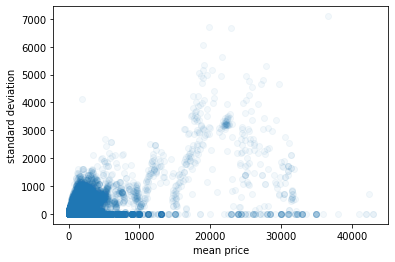

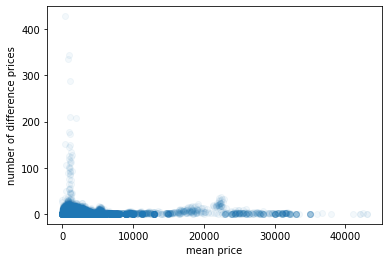

percentage of item price unchanged 0.5066873720871782
percentage of number of different prices smaller than 3 0.7525582564360346


In [407]:
plt.scatter(price['mean'], price['std'],alpha=0.05)
plt.xlabel("mean price")
plt.ylabel("standard deviation")
#plt.ylim(0, 6000)
#plt.xlim(0,50000)
plt.show()
plt.scatter(price['mean'], price['len'],alpha=0.05)
plt.xlabel("mean price")
plt.ylabel("number of difference prices")
#plt.ylim(0, 500)
#plt.xlim(0,50000)
plt.show()

print('percentage of item price unchanged',len(price[price['len']==1])/len(price))
print('percentage of number of different prices smaller than 3',len(price[price['len']<3])/len(price))

Those price changes might cause sale to fluctuate. However, I cannot know the future price. Thus, I will leave this variable alone for now.

In [408]:
#examine how much price variation per item and shop
price_std_percentage=sales.groupby(['item_id','shop_id']).item_price.std().fillna(0)/sales.groupby(['item_id','shop_id']).item_price.mean().fillna(0)
print('standard deviation not exceeds 50% of its mean:',price_std_percentage[price_std_percentage<0.5].shape[0]/price_std_percentage.shape[0])
price_std_percentage[price_std_percentage>=0.5].unstack()

standard deviation not exceeds 50% of its mean: 0.9678736849664284


shop_id,2,3,4,5,6,7,10,12,14,15,16,18,19,21,22,24,25,26,28,31,34,35,36,37,38,39,41,42,44,45,46,47,48,49,50,52,53,55,56,57,58,59
item_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
32,NaN,NaN,NaN,NaN,NaN,NaN,0.582367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.514147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.518376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.661731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.661731,NaN,NaN,0.661731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
968,NaN,NaN,NaN,0.502143,NaN,NaN,NaN,NaN,0.557642,NaN,NaN,0.578439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.526563
969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.664510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.664510,NaN,NaN,0.643333,NaN,NaN,NaN,NaN,NaN
978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.562715,NaN,NaN,NaN,NaN,NaN,0.630542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.601928,NaN,NaN,NaN,0.519498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.578636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.578636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.627188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now I transform the transaction records into the dataframe with each entry for each month per shop and per item.

In [409]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df
from itertools import *

    
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']
    
# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
    
    # Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)


def sale_prepossesing(sales, grid):    
    # Groupby data to get shop-item-month aggregates
    gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})#'item_cnt_day'
    
    # Fix column names
    gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
    
    # Join it to the grid
    all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)
    #all_data['target']=all_data['target'].clip(0,20)
    # Same as above but with shop-month aggregates
    gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
    gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
    all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num'])#.fillna(0)
    
    # Same as above but with item-month aggregates
    gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
    gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
    all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num'])#.fillna(0)
    
    
    # Same as above but with shop-item-month revenue aggregates
    gb = sales.groupby(index_cols,as_index=False).agg({'revenue':{'revenue':'sum'}})
    gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
    all_data = pd.merge(all_data, gb, how='left', on=index_cols)#.fillna(0)
    
    # Same as above but with shop-revenue-month aggregates
    #gb = sales.groupby(index_cols,as_index=False).agg({'month':{'month':'mean'}})
    #gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
    #all_data = pd.merge(all_data, gb, how='left', on=index_cols)#.fillna(0)
    
    # Same as above but with shop-item-month item price mean
    gb = sales.groupby(index_cols,as_index=False).agg({'item_price':{'item_price':'mean'}})
    gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
    all_data = pd.merge(all_data, gb, how='left', on=index_cols)#.fillna(0)
    
    ##find out the first month with records
    gb = all_data.groupby(['shop_id','item_id'],as_index=False).date_block_num.min()
    gb=gb.rename(columns={'date_block_num':'start_month'})
    all_data=all_data.merge(gb,how="left")#.fillna(0)
    
    ##add item category and shop information into the data set
    all_data=all_data.merge(items, how='left')
    all_data=all_data.merge(item_categories,how="left")
    all_data=all_data.merge(shops,how="left")
    
    # Downcast dtypes from 64 to 32 bit to save memory
    all_data = downcast_dtypes(all_data)
    del grid, gb 
    all_data['revenue']=all_data['revenue'].fillna(0)
    all_data['month']=all_data['date_block_num']%12+1
    gc.collect();
    return(all_data)
all_data=sale_prepossesing(sales, grid)



C:\Users\xianyua\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\groupby\generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [410]:
#all_data= all_data[np.isfinite(all_data['target'])]

all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,revenue,item_price,start_month,item_name,item_category_id,item_category_name,item_category_meta,shop_name,city,month
0,59,22154,0,1.0,452.0,16.0,999.0,999.0,0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,Кино,"Ярославль ТЦ ""Альтаир""",Ярославль,1
1,59,2574,0,2.0,452.0,84.0,798.0,399.0,0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,Музыка,"Ярославль ТЦ ""Альтаир""",Ярославль,1
2,59,2607,0,0.0,452.0,18.0,0.0,NaN,0,DEPECHE MODE The Best Of 1,55,Музыка - CD локального производства,Музыка,"Ярославль ТЦ ""Альтаир""",Ярославль,1
3,59,2614,0,0.0,452.0,16.0,0.0,NaN,0,DEPECHE MODE Violator,55,Музыка - CD локального производства,Музыка,"Ярославль ТЦ ""Альтаир""",Ярославль,1
4,59,2808,0,15.0,452.0,689.0,14985.0,999.0,0,"Diablo III [PC, Jewel, русская версия]",30,Игры PC - Стандартные издания,Игры,"Ярославль ТЦ ""Альтаир""",Ярославль,1


In [411]:
##def extract_last_sale(x):
#    temp=all_data[(all_data['shop_id']==all_data['shop_id'][x])&
#             (all_data['item_id']==all_data['item_id'][x])]
#    
#    for i in range(all_data['date_block_num'][x]-1,-1,-1):
#        if temp[temp['date_block_num']==all_data['date_block_num'][x]].shape[0]==1:
#            if temp[temp['date_block_num']==all_data['date_block_num'][x]].target.values>0:
#                return(temp[temp['date_block_num']==all_data['date_block_num'][x]].target.values)
#                break
#    
#temp=pd.Series(range(all_data.shape[0]))
#
#all_data['last_sale']=temp.apply(lambda x:extract_last_sale(x)  )

Here shows one example for an item with low sale and another item with high sale.

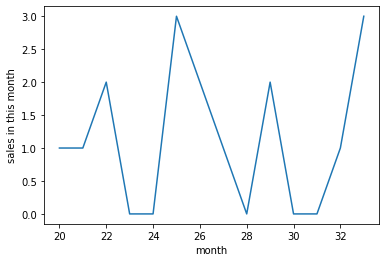

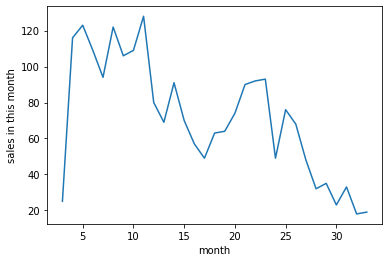

In [412]:
#See a few examples of item sales pershop
#temp=all_data.groupby(['shop_id','item_id']).target.mean()
#temp
plt.plot(all_data[(all_data['shop_id']==2)&(all_data['item_id']==486)].date_block_num,
            all_data[(all_data['shop_id']==2)&(all_data['item_id']==486)].target)
plt.xlabel("month")
plt.ylabel("sales in this month")
plt.show()
plt.plot(all_data[(all_data['shop_id']==59)&(all_data['item_id']==20949)].date_block_num,
            all_data[(all_data['shop_id']==59)&(all_data['item_id']==20949)].target)
plt.xlabel("month")
plt.ylabel("sales in this month")
plt.show()
### There is a huge bump at December, maybe due to Christmas sale. Thus, it might be important take which month is important

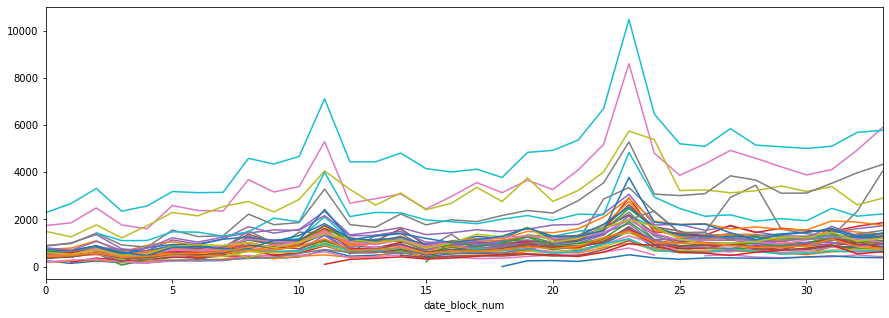

In [413]:
#total sale in each shop
all_data.groupby(['date_block_num','shop_id']).target.sum().unstack().plot(figsize=(15,5),legend=False)
### There is a huge bump at December, maybe due to Christmas sale. Thus, it might be important take which month is important

It appears the sales showing annual fluctuation.

In [414]:
#This part discarded, since I removed the item and shops not in the final testset
#It turns out some of the shops do not have sales in most of the time slots, such as shop #0,#1,#11. They may affect the training result negatively.
#all_data.groupby(['date_block_num','shop_id']).target.sum().unstack()

In [415]:
#all_data=all_data[all_data['shop_id'].isin (np.sort(test.shop_id.unique()))]
#all_data.groupby(['date_block_num','shop_id']).target.sum().unstack()
#Now all shops have some records before Novermber 2015. One exception shop#36 only have one record in October 2015. 
#all_data.groupby(['date_block_num','shop_id']).target.sum().unstack().head

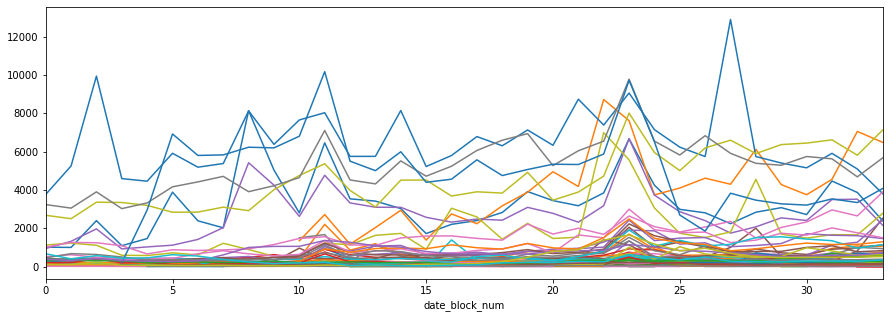

In [416]:
#now, I will repeat the same process for the item category
all_data.groupby(['date_block_num','item_category_id']).target.sum().unstack().plot(figsize=(15,5),legend=False)

In [417]:
#This part discarded, since I removed the item and shops not in the final testset
#all_data.groupby(['date_block_num','item_category_id']).target.sum().unstack()
#Similarly, I saw some category id has few records.
#So I map item category to each test item in the test set. Then see which item_category are used.
#test_temp=test.merge(items,how='left')
#all_data=all_data[all_data['item_category_id'].isin (np.sort(test_temp.item_category_id.unique()))]
#all_data.groupby(['date_block_num','item_category_id']).target.sum().unstack()
#after remove those item category id not in the test set. Item_category_id #0 remains. Let me see its occurance in the testset.
#print('item category#0 item number need to be predicted:',test_temp[test_temp['item_category_id']==0].shape[0])
#Similary I will remove it and do prediction individually for it
#all_data=all_data[all_data['item_category_id']!=0]
#all_data.groupby(['date_block_num','item_category_id']).target.sum().unstack()

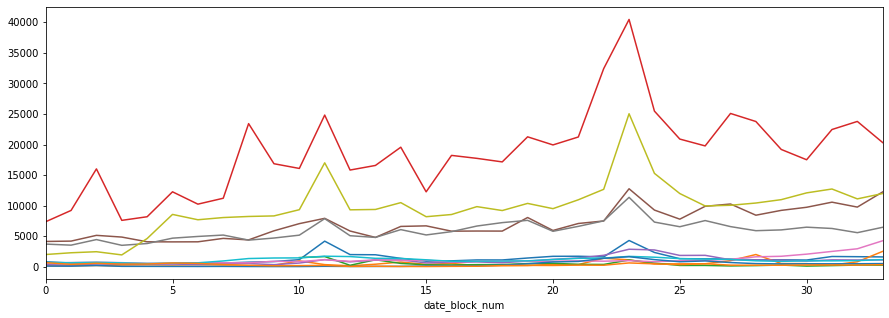

In [418]:
#now, I will repeat the same process for the cities
all_data.groupby(['date_block_num','item_category_meta']).target.sum().unstack().plot(figsize=(15,5),legend=False)

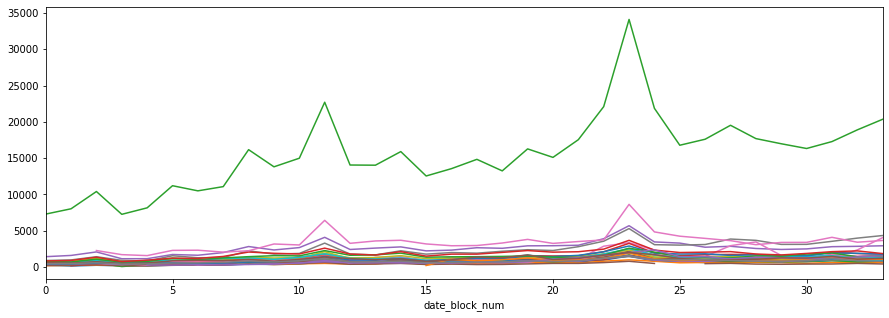

In [419]:
#now, I will repeat the same process for the regions
all_data.groupby(['date_block_num','city']).target.sum().unstack().plot(figsize=(15,5),legend=False)


Now, Let me see the distribution the item sale per shop per item. The distribution is skewed,

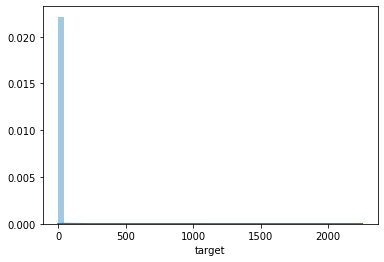

In [420]:
import seaborn as sns
sns.distplot(all_data['target']);

Since the final test dataset restrict the sale higher than 20 as 20. I do the same here

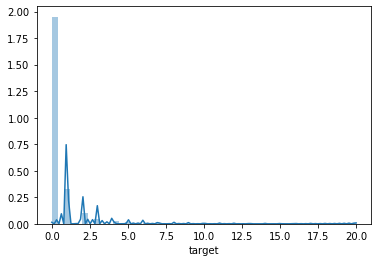

In [421]:
sns.distplot(all_data['target'].clip(0,20));


It turns out most of item sales is 0. 10% of them is 1.
Almost all of them is smaller than 5. This is consistent in the last two months

In [422]:
print('sales is 0:',(all_data[all_data['target']==0].shape[0])/(all_data.shape[0]))
print('sales smaller than 1:',(all_data[all_data['target']<=1].shape[0])/(all_data.shape[0]))#0 and 1
print('sales smaller than 2:',(all_data[all_data['target']<=2].shape[0])/(all_data.shape[0]))
print('sales smaller than 5:',(all_data[all_data['target']<=5].shape[0])/(all_data.shape[0]))

sales is 0: 0.7806420486284226
sales smaller than 1: 0.9123202936652441
sales smaller than 2: 0.9525330750437987
sales smaller than 5: 0.9836918125585233


In [423]:
sold_number=all_data[ all_data['date_block_num'] == 33]['target']
print('sales is 0:',sold_number[sold_number<=0].shape[0]/sold_number.shape[0] )
print('sales smaller than 1:',sold_number[sold_number<=1].shape[0]/sold_number.shape[0] )
print('sales smaller than 5:',sold_number[sold_number<=5].shape[0]/sold_number.shape[0] )

sales is 0: 0.8276684124977425
sales smaller than 1: 0.9436397567876709
sales smaller than 5: 0.9919210161940882


In [424]:
sold_number=all_data[ all_data['date_block_num'] == 32]['target']
print('sales is 0:',sold_number[sold_number<=0].shape[0]/sold_number.shape[0] )
print('sales smaller than 1:',sold_number[sold_number<=2].shape[0]/sold_number.shape[0] )
print('sales smaller than 5:',sold_number[sold_number<=5].shape[0]/sold_number.shape[0] )

sales is 0: 0.8224887455486125
sales smaller than 1: 0.969925418262447
sales smaller than 5: 0.9906940804945239


In [425]:
##Now I will take look of the final test set
index1 = pd.MultiIndex.from_arrays([all_data[col] for col in ['item_id', 'shop_id']])
index2 = pd.MultiIndex.from_arrays([test[col] for col in ['item_id', 'shop_id']])
all_data_testing=all_data.loc[index1.isin(index2)]

The distribution of length of records in month(i.e. the number of months of records for each item in each shop) for each item in the each shop

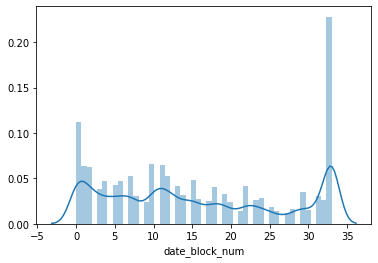

In [426]:
sns.distplot(33-all_data_testing.groupby(['shop_id','item_id']).date_block_num.min())


In [427]:
lastest_data=33-all_data_testing.groupby(['shop_id','item_id']).date_block_num.min()

In [428]:
print('proportion of data more than 3 months record:',lastest_data[lastest_data>=3].shape[0]/lastest_data.shape[0])
print('proportion of data more than 6 months record:',lastest_data[lastest_data>=6].shape[0]/lastest_data.shape[0])
print('proportion of data more than 12 months record:',lastest_data[lastest_data>=12].shape[0]/lastest_data.shape[0])

proportion of data more than 3 months record: 0.838882099081601
proportion of data more than 6 months record: 0.7526814104091972
proportion of data more than 12 months record: 0.5605681800893549


Before generating the mean encoding I first separate data into train validation and test set.

In [429]:
last_block=33
Val_block= 32
dates = all_data['date_block_num']

filename = 'all_data'
pickle.dump(all_data, open(filename, 'wb'))

X_train_prep = all_data.loc[dates <  Val_block]
X_val_prep =  all_data.loc[dates <= Val_block]
X_test_prep =  all_data.loc[dates <= last_block]

Next, I will do the mean encoding for those categories

In [430]:
def mean_encoding(all_data):#, month):
    #I removed the mean encoding I did before, since I found there is a serious overfitting, due to mean encoding including the sale of the month we want to predict
   
   # Calculate a mapping: {item_id: target_mean}
   # mean  = all_data[all_data['date_block_num']<month].groupby('item_category_name').target.mean()
    # In our non-regularized case we just *map* the computed means to the `item_id`'s
    #all_data['item_category_name_enc'] = all_data['item_category_name'].map(mean )
    # Calculate a mapping: {item_id: target_mean}
    #mean  = all_data[all_data['date_block_num']<month].groupby('item_category_meta').target.mean()
    # In our non-regularized case we just *map* the computed means to the `item_id`'s
    #all_data['meta_category_enc'] = all_data['item_category_meta'].map(mean )
    # Calculate a mapping: {item_id: target_mean}
    #mean  = all_data[all_data['date_block_num']<month].groupby('city').target.mean()
    # In our non-regularized case we just *map* the computed means to the `item_id`'s
    #all_data['city_enc'] = all_data['city'].map(mean )
    # Calculate a mapping: {item_id: target_mean}
    #mean  = all_data[all_data['date_block_num']<month].groupby('item_id').target.mean()
    # In our non-regularized case we just *map* the computed means to the `item_id`'s
    #all_data['item_id_enc'] = all_data['item_id'].map(mean )
    # Calculate a mapping: {item_id: target_mean}
    #mean  = all_data[all_data['date_block_num']<month].groupby('shop_id').target.mean()
    # In our non-regularized case we just *map* the computed means to the `item_id`'s
    #all_data['shop_id_enc'] = all_data['shop_id'].map(mean )
    
    #mean  = all_data[all_data['date_block_num']<month].groupby(['city','item_category_meta'],as_index=False).target.mean()
    #mean=mean.rename(columns={'target':'city_meta_cat_enc'})
    #all_data = all_data.merge(mean,how='left' )
    #
    #mean  = all_data[all_data['date_block_num']<month].groupby(['city','item_category_id'],as_index=False).target.mean()
    #mean=mean.rename(columns={'target':'city_cat_enc'})
    #all_data = all_data.merge(mean,how='left' )
    #
    #mean  = all_data[all_data['date_block_num']<month].groupby(['city','item_id'],as_index=False).target.mean()
    #mean=mean.rename(columns={'target':'city_item_enc'})
    #all_data = all_data.merge(mean,how='left' )
    #
    #mean  = all_data[all_data['date_block_num']<month].groupby(['shop_id','item_category_meta'],as_index=False).target.mean()
    #mean=mean.rename(columns={'target':'shop_meta_item_enc'})
    #all_data = all_data.merge(mean,how='left' )
    #
    #mean  = all_data[all_data['date_block_num']<month].groupby(['shop_id','item_category_id'],as_index=False).target.mean()
    #mean=mean.rename(columns={'target':'shop_item_enc'})
    #all_data = all_data.merge(mean,how='left' )
    
    ##consider each month mean encoding
    # Calculate a mapping: {item_id: target_mean}
    mean  = all_data.groupby(['item_category_name','date_block_num'],as_index=False).target.mean()
    # In our non-regularized case we just *map* the computed means to the `item_id`'s
    mean=mean.rename(columns={'target':'item_cat_month_enc'})
    all_data = all_data.merge(mean,how='left' )
    # Calculate a mapping: {item_id: target_mean}
    mean  = all_data.groupby(['item_category_meta','date_block_num'],as_index=False).target.mean()
    # In our non-regularized case we just *map* the computed means to the `item_id`'s
    mean=mean.rename(columns={'target':'item_meta_month_enc'})
    all_data = all_data.merge(mean,how='left' )
    # Calculate a mapping: {item_id: target_mean}
    mean  = all_data.groupby(['city','date_block_num'],as_index=False).target.mean()
    # In our non-regularized case we just *map* the computed means to the `item_id`'s
    mean=mean.rename(columns={'target':'city_month_enc'})
    all_data = all_data.merge(mean,how='left' )
    # Calculate a mapping: {item_id: target_mean}
    mean  = all_data.groupby(['item_id','date_block_num'],as_index=False).target.mean()
    # In our non-regularized case we just *map* the computed means to the `item_id`'s
    mean=mean.rename(columns={'target':'item_month_enc'})
    all_data = all_data.merge(mean,how='left' )
    # Calculate a mapping: {item_id: target_mean}
    mean  = all_data.groupby(['shop_id','date_block_num'],as_index=False).target.mean()
    # In our non-regularized case we just *map* the computed means to the `item_id`'s
    mean=mean.rename(columns={'target':'shop_month_enc'})
    all_data = all_data.merge(mean,how='left' )
    
    mean  = all_data.groupby(['city','item_category_meta','date_block_num'],as_index=False).target.mean()
    mean=mean.rename(columns={'target':'city_meta_cat_month_enc'})
    all_data = all_data.merge(mean,how='left' )
    
    mean  = all_data.groupby(['city','item_id','date_block_num'],as_index=False).target.mean()
    mean=mean.rename(columns={'target':'city_item_month_enc'})
    all_data = all_data.merge(mean,how='left' )
    
    mean  = all_data.groupby(['shop_id','item_category_meta','date_block_num'],as_index=False).target.mean()
    mean=mean.rename(columns={'target':'shop_meta_item_month_enc'})
    all_data = all_data.merge(mean,how='left' )
    
    mean  = all_data.groupby(['shop_id','item_category_id','date_block_num'],as_index=False).target.mean()
    mean=mean.rename(columns={'target':'shop_item_cat_month_enc'})
    all_data = all_data.merge(mean,how='left' )    
    
    return(all_data)

In [431]:
X_train_prep =mean_encoding(X_train_prep)#,31)
X_val_prep =mean_encoding(X_val_prep)#,32)
X_test_prep =mean_encoding(X_test_prep)#,33)

In [432]:
X_train_prep=X_train_prep.drop(columns=['shop_name','item_category_name','item_category_meta','city','item_name'])
X_val_prep=X_val_prep.drop(columns=['shop_name','item_category_name','item_category_meta','city','item_name'])
X_test_prep=X_test_prep.drop(columns=['shop_name','item_category_name','item_category_meta','city','item_name'])

For month unique features, I add the sales for several months ago for each 

In [433]:
def add_lag(all_data):
    all_data_input=all_data.drop(columns=['item_category_id'])#,'city_cat_enc','city_item_enc','city_enc','city_meta_cat_enc',
              # 'item_category_name_enc','meta_category_enc','shop_meta_item_enc','shop_item_enc','shop_id_enc','item_id_enc'])

    index_cols2 = ['shop_id', 'item_id', 'date_block_num']#,'item_category_id',
    from tqdm import tqdm_notebook 
    # List of columns that we will use to create lags
    #cols_to_rename =  list(all_data.columns.difference(index_cols)) 
    cols_to_rename = ['target',
                      'target_item',
                      'target_shop',
                     'item_cat_month_enc','item_meta_month_enc','city_month_enc',
                    'item_month_enc','shop_month_enc', 
                       'city_item_month_enc',
                       'shop_meta_item_month_enc',
                       'shop_item_cat_month_enc',
                      'city_meta_cat_month_enc'
                       ]#,
                     #'revenue']
    
    shift_range = [1, 2, 3, 4, 6,7,11,12,13]
    
    for month_shift in tqdm_notebook(shift_range):
        train_shift = all_data_input[index_cols2+ cols_to_rename].copy()#index_cols2 
        
        train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
        
        foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
        train_shift = train_shift.rename(columns=foo)
    
        all_data = pd.merge(all_data, train_shift, on=index_cols2, how='left')#.fillna(0)
    
    del train_shift
    
    # Don't use old data from year 2013
    #all_data= all_data[all_data['date_block_num'] >= 12] 
    
    # List of all lagged features
    fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
    # We will drop these at fitting stage
    to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols2))) + ['date_block_num'] 
    
    # Category for each item
    #item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()
    
    #all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
    all_data = downcast_dtypes(all_data)
    return(all_data)
    gc.collect();    

In [434]:
X_train_prep=add_lag(X_train_prep)
X_val_prep=add_lag(X_val_prep)
X_test_prep=add_lag(X_test_prep)

In [435]:
###construct LSTM model data
temp=X_train_prep[['shop_id','item_id','date_block_num','target']]
temp.groupby(['shop_id','item_id'])

Here add the some features for difference of sales in different months.

In [436]:
#all_data['11-12 diff']=all_data['target_lag_11']-all_data['target_lag_12'] 
#all_data['11-12 item diff']=all_data['target_item_lag_11']-all_data['target_item_lag_12'] 
#all_data['11-12 shop diff']=all_data['target_shop_lag_11']-all_data['target_shop_lag_12'] 
def add_differences(all_data):    
    all_data['1-2 diff']=all_data['target_lag_1']-all_data['target_lag_2'] 
    all_data['1-2 item diff']=all_data['target_item_lag_1']-all_data['target_item_lag_2'] 
    all_data['1-2 shop diff']=all_data['target_shop_lag_1']-all_data['target_shop_lag_2'] 
    
    all_data['1-3 diff']=all_data['target_lag_1']-all_data['target_lag_3'] 
    all_data['1-3 item diff']=all_data['target_item_lag_1']-all_data['target_item_lag_3'] 
    all_data['1-3 shop diff']=all_data['target_shop_lag_1']-all_data['target_shop_lag_3'] 
    
    all_data['1-13 diff']=all_data['target_lag_1']-all_data['target_lag_13'] 
    all_data['1-13 item diff']=all_data['target_item_lag_1']-all_data['target_item_lag_13'] 
    all_data['1-13 shop diff']=all_data['target_shop_lag_1']-all_data['target_shop_lag_13'] 
    #
    all_data['1-7 diff']=all_data['target_lag_7']-all_data['target_lag_7'] 
    all_data['1-7 item diff']=all_data['target_item_lag_7']-all_data['target_item_lag_7'] 
    all_data['1-7 shop diff']=all_data['target_shop_lag_7']-all_data['target_shop_lag_7'] 
    #
    all_data['1-4 diff']=all_data['target_lag_4']-all_data['target_lag_4'] 
    all_data['1-4 item diff']=all_data['target_item_lag_4']-all_data['target_item_lag_4'] 
    all_data['1-4 shop diff']=all_data['target_shop_lag_4']-all_data['target_shop_lag_4'] 
    return(all_data)



In [437]:
X_train_prep=add_differences(X_train_prep)
X_val_prep=add_differences(X_val_prep)
X_test_prep=add_differences(X_test_prep)

In [440]:
to_drop_cols=['target_shop',
              'target_item',
              'revenue',
              'target',
              #'item_category_id',
              #'item_id',
              'date_block_num', 'city_meta_cat_month_enc',
              'item_cat_month_enc','item_meta_month_enc','city_month_enc',
                'item_month_enc','shop_month_enc', 
                   'city_item_month_enc',
                   'shop_meta_item_month_enc',
                   'shop_item_cat_month_enc',
              'target_lag_7','target_item_lag_7','target_shop_lag_7',
              'target_lag_11','target_item_lag_11','target_shop_lag_11',
              'target_lag_12','target_item_lag_12','target_shop_lag_12',
              'target_lag_13','target_item_lag_13','target_shop_lag_13',
              'item_cat_month_enc_lag_12','item_meta_month_enc_lag_12','city_month_enc_lag_12',
              'item_month_enc_lag_12','shop_month_enc_lag_12','shop_item_cat_month_enc_lag_12', 
              'city_item_month_enc_lag_12','shop_meta_item_month_enc_lag_12',
              
               'item_cat_month_enc_lag_11','item_meta_month_enc_lag_11','city_month_enc_lag_11',
              'item_month_enc_lag_11','shop_month_enc_lag_12','shop_item_cat_month_enc_lag_11', 
              'city_item_month_enc_lag_11','shop_meta_item_month_enc_lag_11',
              
               'item_cat_month_enc_lag_13','item_meta_month_enc_lag_13','city_month_enc_lag_13',
              'item_month_enc_lag_13','shop_month_enc_lag_13','shop_item_cat_month_enc_lag_13', 
              'city_item_month_enc_lag_13','shop_meta_item_month_enc_lag_13',
       
               'item_cat_month_enc_lag_7','item_meta_month_enc_lag_7','city_month_enc_lag_7',
              'item_month_enc_lag_7','shop_month_enc_lag_7','shop_item_cat_month_enc_lag_7', 
              'city_item_month_enc_lag_7','shop_meta_item_month_enc_lag_7',
              
              'target_lag_4','target_item_lag_4','target_shop_lag_4',
               'item_cat_month_enc_lag_4','item_meta_month_enc_lag_4','city_month_enc_lag_4',
              'item_month_enc_lag_4','shop_month_enc_lag_4','shop_item_cat_month_enc_lag_4', 
              'city_item_month_enc_lag_4','shop_meta_item_month_enc_lag_4',
              
        
              'item_price'
             #'shop_id'
             ]
#dates = all_data_go['date_block_num']
#dates_train = dates[dates <  Val_block]
#dates_val  = dates[dates == Val_block]
##dates_test  = dates[dates == last_block]

#X_train = all_data_go.loc[dates <  Val_block].drop(to_drop_cols, axis=1)#.fillna(0)
#X_val =  all_data_go.loc[dates == Val_block].drop(to_drop_cols, axis=1)#.fillna(0)
#X_test =  all_data_go.loc[dates == last_block].drop(to_drop_cols, axis=1)#.fillna(0)
#
#y_train = all_data_go.loc[dates <  Val_block, 'target'].values.clip(0,20)#np.log(all_data_go.loc[dates <  last_block, 'target'].values+2)
#y_val = all_data_go.loc[dates ==  Val_block, 'target'].values.clip(0,20)
#y_test =  all_data_go.loc[dates == last_block, 'target'].values.clip(0,20)#np.log(all_data_go.loc[dates == last_block, 'target'].values+2)

preparing the final training, validation and test set by separating them into features and target (i.e. X and Y).

In [441]:
X_train = X_train_prep.loc[dates <  Val_block].drop(to_drop_cols, axis=1)#.fillna(0)
X_val = X_val_prep.loc[dates == Val_block].drop(to_drop_cols, axis=1)#.fillna(0)
X_test = X_test_prep.loc[dates == last_block].drop(to_drop_cols, axis=1)#.fillna(0)
#
y_train = X_train_prep.loc[dates <  Val_block, 'target'].values.clip(0,20)#np.log(all_data_go.loc[dates <  last_block, 'target'].values+2)
y_val = X_val_prep.loc[dates ==  Val_block, 'target'].values.clip(0,20)
y_test =  X_test_prep.loc[dates == last_block, 'target'].values.clip(0,20)#np.log(all_data_go.loc[dates == last_block, 'target'].values+2)

In [442]:
#pd.set_option('display.max_columns', None)
#all_data[(all_data['shop_id']==2)&((all_data['item_id']==1523))&(all_data['date_block_num']==12)]

I tried XGboost model here first

In [443]:
from xgboost import XGBRegressor
from xgboost import plot_importance
import xgboost
xgb = XGBRegressor( max_depth=10, n_estimators=100, min_child_weight=300,  colsample_bytree=0.8, 
                      subsample=0.8,   eta=0.3,   nthread=-2,  seed=42)

xgb.fit(  X_train,   y_train,  eval_metric="rmse", 
         eval_set=[(X_train, y_train), (X_val, y_val)],   verbose=True,  early_stopping_rounds = 10)

[16:47:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.61667	validation_1-rmse:1.2762
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.55109	validation_1-rmse:1.23561
[2]	validation_0-rmse:1.49327	validation_1-rmse:1.20028
[3]	validation_0-rmse:1.43825	validation_1-rmse:1.16497
[4]	validation_0-rmse:1.38996	validation_1-rmse:1.13815
[5]	validation_0-rmse:1.34859	validation_1-rmse:1.11581
[6]	validation_0-rmse:1.31433	validation_1-rmse:1.09806
[7]	validation_0-rmse:1.28797	validation_1-rmse:1.08316
[8]	validation_0-rmse:1.26177	validation_1-rmse:1.06952
[9]	validation_0-rmse:1.23938	validation_1-rmse:1.05734
[10]	validation_0-rmse:1.22103	validation_1-rmse:1.04807
[11]	validation_0-rmse:1.2043	validation_1-rmse:1.04151
[12]	

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=300, missing=None, n_estimators=100,
             n_jobs=1, nthread=-2, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             silent=None, subsample=0.8, verbosity=1)

In [444]:
#from sklearn.model_selection import GridSearchCV
## Create the parameter grid based on the results of random search 
#param_grid = {   'max_depth':[5,10],
#              'n_estimators':[100,200,400,500], 
#              'min_child_weight':[300],  
#              'colsample_bytree':[0.8], 
#              'subsample':[0.8],  
#              'eta':[0.3],
#}
## Create a based model
#xgb = XGBRegressor(  nthread=-2,  seed=42)
## Instantiate the grid search model
#grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, 
#                          cv = 2, verbose = 2)
## Fit the grid search to the data
#grid_search.fit(X_train, y_train, eval_metric="rmse", 
#         eval_set=[(X_train, y_train), (X_val, y_val)],   verbose=True,  early_stopping_rounds = 10)
#grid_search.best_params_

#best_grid = grid_search.best_estimator_
#grid_accuracy = evaluate(best_grid, test_features, test_labels)

In [396]:
filename = 'xgbmodel'
pickle.dump(xgb, open(filename, 'wb'))
xgb=pickle.load(open('xgbmodel', 'rb'))

[16:40:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Check the prediction accuracy for the testset

In [461]:
from math import sqrt 
from sklearn.metrics import mean_squared_error
print('Test rmse for xgb is %f' % sqrt(mean_squared_error(y_test, xgb.predict(X_test).clip(0,20))))
#sqrt(mean_squared_error(y_test_meta, pred_lr_meta))
#with only the shop and items in the test set: 0.79, the public score is 1.041
#with all the shop and items in the dataset: 0.778,however the public score is only 1.39. 
#with  only the shop and items combination in the test set: 0.798058,however the public score is only 1.044. 

Test rmse for xgb is 0.971939


Examine the feature importance for the xgboost model.

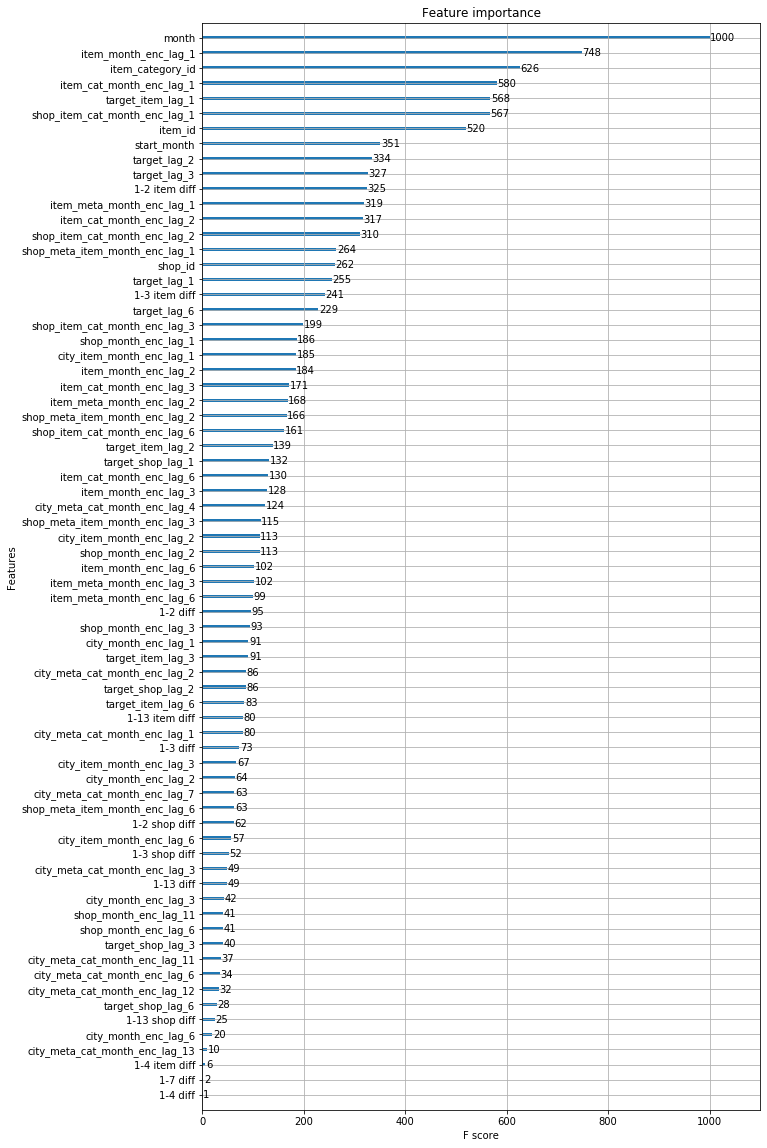

In [446]:
from xgboost import plot_importance
fig, ax = plt.subplots(1,1,figsize=(10,20))
plot_importance(xgb,ax=ax)

In [467]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
lr = LinearRegression(normalize=True)
lr.fit(X_train.fillna(0).values, y_train)
pred_lr = lr.predict(X_val.fillna(0).values)

print('Test R-squared for linreg is %f' % r2_score(y_val, pred_lr))
print('Test rmse for linreg is %f' % sqrt(mean_squared_error(y_val, pred_lr)))


Test R-squared for linreg is 0.227202
Test rmse for linreg is 1.164088


The inear regression model does not perform well. Discarded.

Try lightGBM model.I tuned hyperparameters a little bit. More tunning is required.

In [344]:
from sklearn.metrics import mean_squared_error
from math import sqrt

import lightgbm as lgb

best_rmse=10
for learning_rate in [0.1,0.15,0.2,0.4]:
    for feature_fraction in [0.5,0.75,1]:
        for bagging_freq in [1,2,4]:
            for bagging_fraction in [0.5,0.75,1]:   
         
               
                lgb_params = {
                      'feature_fraction': feature_fraction,
                       'metric': 'rmse',#'binary_logloss',#
                       'nthread':10, 
                       'min_data_in_leaf': 2**7, 
                       'bagging_fraction': bagging_fraction, 
                       'learning_rate': learning_rate, 
                       'objective': 'mse', 
                       'bagging_seed': 2**7, 
                       'num_leaves': 2**7,
                       'bagging_freq':bagging_freq,
                       'verbose':0 
                      
                      }
                model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train))
                pred_lgb = model.predict(X_val)
                if sqrt(mean_squared_error(y_val, pred_lgb))<best_rmse:
                    learning_rate_b=learning_rate
                    feature_fraction_b=feature_fraction
                    bagging_fraction_b=bagging_fraction
                    bagging_freq_b=bagging_freq
                   
                    best_rmse=sqrt(mean_squared_error(y_val, pred_lgb))
                    print(sqrt(mean_squared_error(y_val, pred_lgb)))


0.9964073547654323
0.9903776441707701
0.9894059534397657
0.9881789376648704
0.9817969668581881
0.9743980478061162


In [460]:
from sklearn.metrics import mean_squared_error
from math import sqrt

import lightgbm as lgb
from sklearn.metrics import r2_score
lgb_params = {
              'feature_fraction': feature_fraction_b,
               'metric': 'rmse',#'binary_logloss',#
               'nthread':10, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': bagging_fraction_b, 
               'learning_rate': learning_rate_b, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':bagging_freq_b,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train))
pred_lgb = model.predict(X_val).clip(0,20)

print('Test R-squared for LightGBM is %f' % r2_score(y_val, pred_lgb))
print('Test rmse for linreg is %f' % sqrt(mean_squared_error(y_val, pred_lgb)))

Test R-squared for LightGBM is 0.417453
Test rmse for linreg is 1.010691


In [449]:
filename = 'lgb_model'
pickle.dump(model, open(filename, 'wb'))

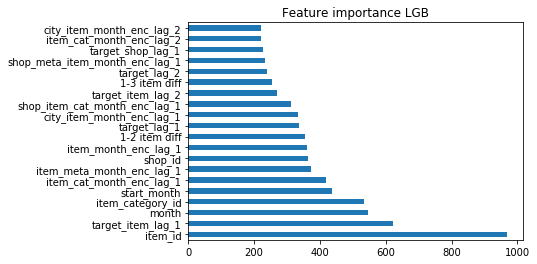

In [499]:
feat_importances = pd.Series(model.feature_importance(), index=X_val.columns)
feat_importances = feat_importances.nlargest(20)
feat_importances.plot(kind='barh')
plt.title('Feature importance LGB')
plt.show()

## Visualization each model

Test rmse for xgb is 0.999681


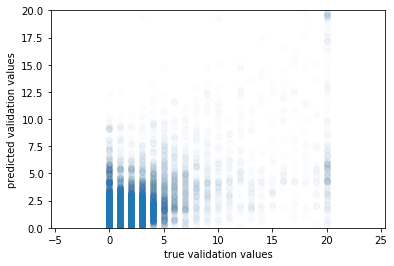

In [462]:
from sklearn.metrics import mean_squared_error
from math import sqrt
plt.scatter(y_val,xgb.predict(X_val),alpha=0.01)
plt.axis('equal')
plt.ylim(0, 20)
plt.xlim(0,20)
plt.xlabel('true validation values')
plt.ylabel('predicted validation values')

print('Test rmse for xgb is %f' % sqrt(mean_squared_error(y_val, xgb.predict(X_val).clip(0,20))))

Test rmse for lr is 1.011205


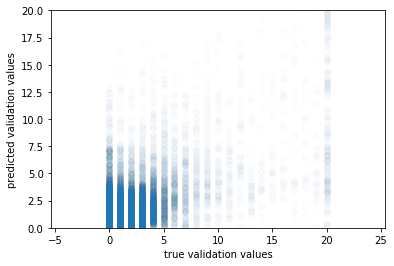

In [451]:
from sklearn.metrics import mean_squared_error
from math import sqrt
plt.scatter(y_val,pred_lgb,alpha=0.01)
plt.axis('equal')
plt.ylim(0, 20)
plt.xlim(0,20)
plt.xlabel('true validation values')
plt.ylabel('predicted validation values')

print('Test rmse for lgb is %f' % sqrt(mean_squared_error(y_val, pred_lgb)))

In [ ]:
See the relationship between prediction values for xgb and lgb models.

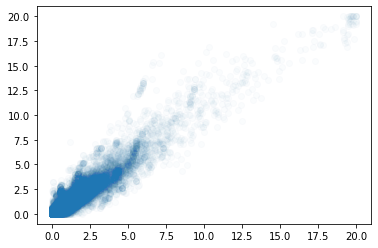

In [464]:
plt.scatter(xgb.predict(X_val).clip(0,20),pred_lgb.clip(0,20),alpha=0.02)

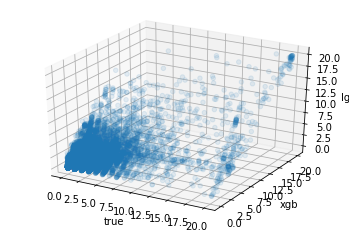

In [465]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
#plt.scatter(xgb.predict(X_val),pred_lgb,alpha=0.1)
ax.scatter3D(y_val, xgb.predict(X_val).clip(0,20),pred_lgb.clip(0,20),alpha=0.1);
ax.set_xlabel('true')
ax.set_ylabel('xgb')
ax.set_zlabel('lgb');



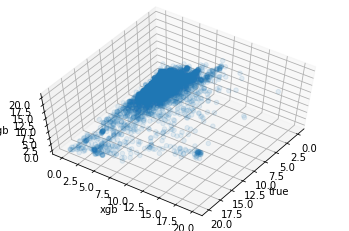

In [466]:
ax.view_init(60, 35)
fig

### ensembling

Here I try stacking the two models together and use random forest tree to predict based on the prediction values of xgb and lgb

In [477]:
X_meta=pd.concat([pd.DataFrame(xgb.predict(X_train)),pd.DataFrame(model.predict(X_train))], axis=1, sort=False)

In [478]:
X_meta

,0,0
0,1.683899,0.955444
1,0.386369,0.215229
2,0.386369,0.215229
3,0.386369,0.215229
4,5.377779,7.040923
5,5.377779,6.254522
6,0.249756,0.090629
7,0.386369,0.215229
8,0.386369,0.215229
9,0.249756,0.090629


In [487]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [4],
    'max_features': [2],
    'min_samples_leaf': [4,5],
    'min_samples_split': [4,5],
    'n_estimators': [50,100]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
grid_search.fit(X_meta.values, y_train)
grid_search.best_params_

#best_grid = grid_search.best_estimator_
#grid_accuracy = evaluate(best_grid, test_features, test_labels)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:  4.8min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  8.2min finished


{'bootstrap': True,
 'max_depth': 4,
 'max_features': 2,
 'min_samples_leaf': 5,
 'min_samples_split': 4,
 'n_estimators': 50}

In [488]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification


clf = RandomForestRegressor(bootstrap=True, max_features=2,min_samples_leaf=5,
                            min_samples_split=4, max_depth=4,random_state=0,n_estimators= 50)#n_estimators=100
clf.fit(X_meta.values, y_train)
#pred_clf = clf.predict(X_meta.values)
#print('Test rmse for training rmse is %f' % sqrt(mean_squared_error(y_train, pred_clf)))
pred_clf = clf.predict(pd.concat([pd.DataFrame(xgb.predict(X_val)),pd.DataFrame(model.predict(X_val))], axis=1, sort=False).values)
print('Test rmse for training rmse is %f' % sqrt(mean_squared_error(y_val, pred_clf)))


Test rmse for training rmse is 1.016507


It turns out simply use ensembling method with linear regression causes slight overfitting. Thus, I gonna use either xgb or lgb model

### submit model


In [494]:
all_data=pickle.load(open('all_data', 'rb'))
#pick all the shop item combination in the test set
index1 = pd.MultiIndex.from_arrays([all_data[col] for col in ['item_id', 'shop_id']])
index2 = pd.MultiIndex.from_arrays([test[col] for col in ['item_id', 'shop_id']])
all_temp=all_data.loc[index1.isin(index2)]
#generate fake entries for 2015 Novermber
temp=all_temp.loc[all_temp['date_block_num']==33]
temp['date_block_num']=34
temp['month']=11
all_temp=all_temp.append(temp)


C:\Users\xianyua\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\xianyua\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [497]:
#repeat the feature engineering for the test set
all_temp=mean_encoding(all_temp).drop(columns=['shop_name','item_category_name','item_category_meta','city','item_name'])
all_temp=add_lag(all_temp)
all_temp=add_differences(all_temp)
dates =all_temp['date_block_num']
all_test=all_temp.loc[dates == 34]
X_in=all_test.drop(to_drop_cols, axis=1)
X_in=X_in.reindex(X_train.columns, axis=1)
#predict data
pred_test=xgb.predict(X_in).clip(0,20)

In [498]:

all_data_new=pd.concat([all_test['shop_id'].reset_index(drop=True),all_test['item_id'].reset_index(drop=True),pd.DataFrame(pred_test)], axis=1, sort=False)#,pd.DataFrame(pred_testset)]
test_temp=test.copy()
test_temp=test_temp.merge(all_data_new,how='left').fillna(0.5)
test_temp=test_temp.rename(columns={0: 'item_cnt_month'})
submit=test_temp.drop(['shop_id','item_id'],axis=1)
submit.to_csv (r'C:\submit.csv', index = None, header=True) 